# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [293]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

In [294]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [295]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import umap_ as UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [296]:
#ds_train = pd.read_csv("C:/Users/maico/Documents/Mestrado/dmeyf2023/datasets/competencia_02.csv")
ds_train = pd.read_csv("/Users/maiconfialho/Documents/Mestrado/2023-2/dmeyf2023/datasets/competencia_02.csv.gz")
ds_train.drop(columns=['valor'], inplace=True)

#gravar no datast apenas os registros com foto_mes inicia com 2019 e menor que 2020
#ds_train = ds_train[ds_train['foto_mes'] < 202000]

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [297]:
ds_hist = ds_train[ds_train["numero_de_cliente"].isin(ds_train[ds_train["clase_ternaria"] == "BAJA+2"]["numero_de_cliente"])]
ds_hist.drop(columns=["clase_ternaria"], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [298]:
clase_train = ds_train["clase_ternaria"].map(lambda x: 1 if x == "BAJA+2" else 0)
ds_bajas = ds_train.query("clase_ternaria == 'BAJA+2'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [299]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'num_iterations': 670,
    'learning_rate': 0.0100738668153211,
    'feature_fraction': 0.413040235996875,
    'verbose': -100,
    'max_bin': 31,
    'min_data_in_leaf': 2858,
    'num_leaves:': 161,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Found `num_iterations` in params. Will use it instead of argument


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [300]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
0,foto_mes,1662
32,mprestamos_personales,720
15,mcuenta_corriente,715
152,Visa_mpagominimo,586
21,mcuentas_saldo,571
...,...,...
121,Master_madelantodolares,0
143,Visa_madelantodolares,0
39,mplazo_fijo_pesos,0
60,cpagodeservicios,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [301]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [302]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.4808704592108158


,1767,7
mprestamos_personales,42814.38,0.215436
cprestamos_personales,5.00,0.047948
cdescubierto_preacordado,1.00,0.039534
Visa_mpagominimo,4363.56,0.034807
Visa_msaldopesos,15540.06,0.031574
...,...,...
mcuentas_saldo,-8022.67,-0.374687
mcuenta_corriente,-7982.80,-0.493024
foto_mes,201904.00,-0.681483
mcaja_ahorro,0.00,-0.849307


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [303]:
shap_bajas.mean().abs().sort_values(ascending=False)


ctrx_quarter                   0.456621
mcaja_ahorro                   0.335996
mpayroll                       0.314000
foto_mes                       0.296298
cpayroll_trx                   0.286302
                                 ...   
cpagodeservicios               0.000000
cpayroll2_trx                  0.000000
mpayroll2                      0.000000
mplazo_fijo_pesos              0.000000
mcuenta_corriente_adicional    0.000000
Length: 153, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

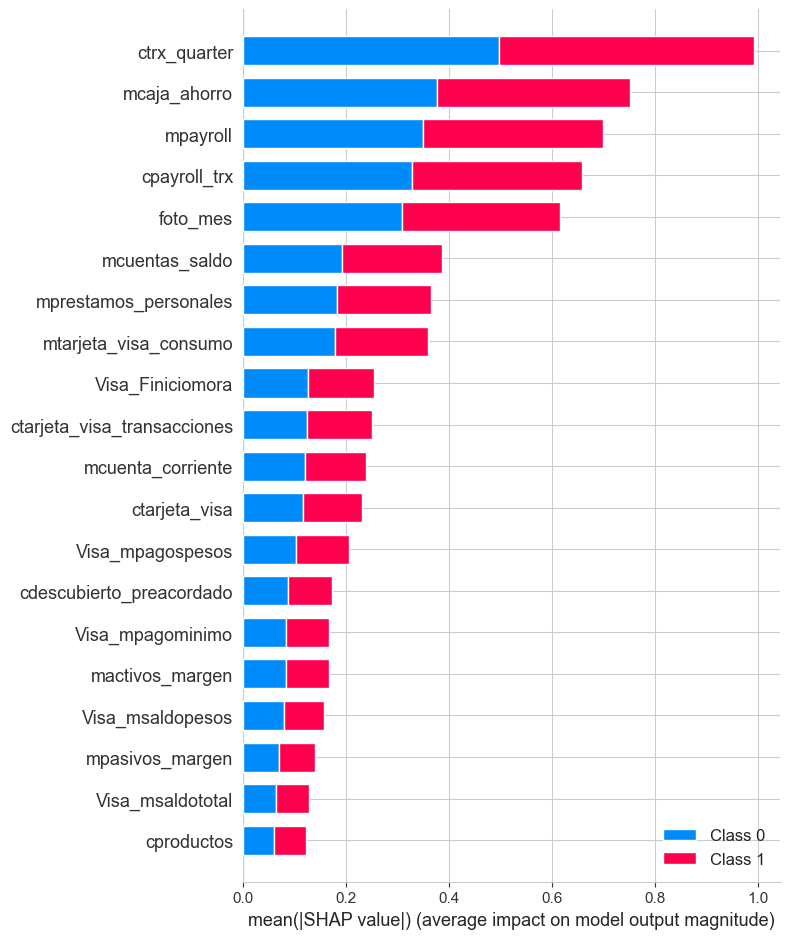

In [304]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


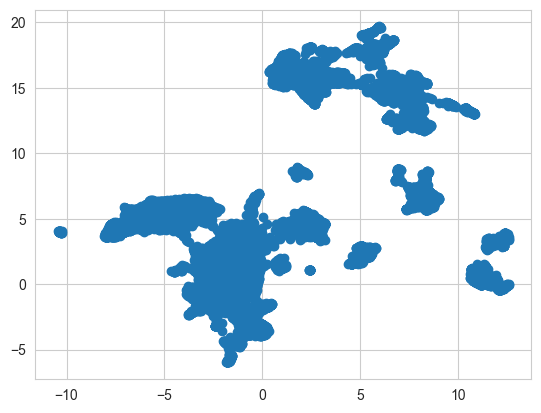

In [305]:
embedding_2d = UMAP.UMAP(
  n_components=2, n_neighbors=40, random_state=100005
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([8.058e+03, 3.365e+03, 1.862e+03, 1.325e+03, 9.090e+02, 6.610e+02,
        5.330e+02, 4.280e+02, 3.500e+02, 2.240e+02, 1.800e+02, 1.430e+02,
        1.250e+02, 8.400e+01, 7.300e+01, 7.400e+01, 6.200e+01, 5.300e+01,
        3.800e+01, 4.400e+01, 4.500e+01, 2.700e+01, 3.000e+01, 4.300e+01,
        1.500e+01, 2.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 2.000e+00]),
 array([1.27737248e-04, 2.70823643e-02, 5.40369913e-02, 8.09916184e-02,
        1.07946245e-01, 1.34900872e-01, 1.61855500e-01, 1.88810127e-01,
        2.15764754e-01, 2.42719381e-01, 2.69674008e-01, 2.96628635e-01,
        3.23583262e-01, 3.50537889e-01, 3.77492516e-01, 4.04447143e-01,
        4.31401770e-01, 4.58356397e-01, 4.85311024e-01, 5.12265651e-01,
        5.39220278e-01, 5.66174905e-01, 5.93129532e-01, 6.20084159e-01,
        6.47038786e-01, 6.73993414e-01, 7.00948041e-01, 7.27902668e-01,
        7.54857295e-01, 7.81811922e-01, 8.08766549e-01]),
 <BarContainer object of 30 artists>)

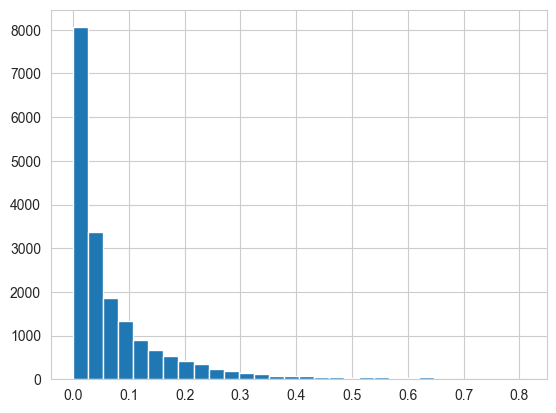

In [306]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

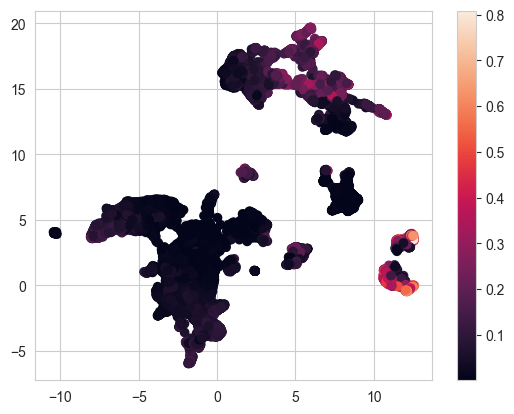

In [307]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


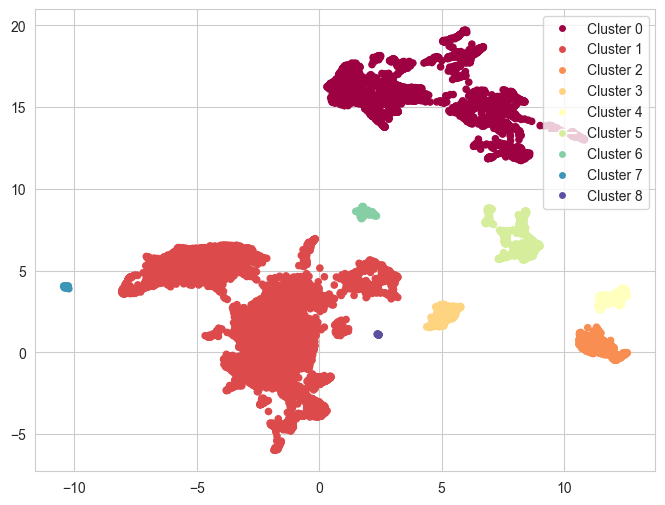

In [376]:
from matplotlib.lines import Line2D  # Importe Line2D


hdb = DBSCAN(eps=0.75) #2.5 - 4 grupos
y = hdb.fit(embedding_2d)

unique_labels = set(y.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='Spectral', marker='o', s=20)

legend_labels = [f'Cluster {label}' if label != -1 else 'Outliers' for label in unique_labels]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label]) for label in unique_labels]

plt.legend(legend_handles, legend_labels, loc='upper right')

plt.show()


In [377]:
np.unique(y.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

Comparamos 2 clusters para ver si cambian sus variables importantes

In [378]:
#criar um novo dataset com os labels
ds_bajas_labels = ds_bajas.copy()
ds_bajas_labels["labels"] = y.labels_

In [379]:
#exibir os labels dos clientes que tem cpayroll_trx > 0
ds_bajas_labels[ds_bajas_labels['cpayroll_trx'] > 0]['labels'].value_counts()

labels
5    1090
2      51
3      45
4      37
1      20
0       4
Name: count, dtype: int64

In [380]:
#criar um novo dataset copia de ds_bajas adicionando o numero_de_cliente que vai ser igual ao numero_de_cliente do ds_hist aonde o index for igual , usar ds_hist.index.get_loc() para localizar o index do cliente no ds_hist
ds_historico_bajas = ds_bajas_labels.copy()
ds_historico_bajas['numero_de_cliente'] = ds_hist.loc[ds_bajas_labels.index, 'numero_de_cliente']

In [381]:
ds_historico_final = pd.concat([ds_historico_bajas, ds_hist], axis=0)   
ds_historico_final['labels'].fillna(ds_historico_final.groupby('numero_de_cliente')['labels'].transform('first'), inplace=True)
ds_historico_final.drop_duplicates(subset=['numero_de_cliente', 'foto_mes'], keep='last', inplace=True)

In [382]:
ds_historico_final['labels'].value_counts()

labels
1.0    172932
0.0     75452
5.0     14626
2.0      6087
3.0      4634
4.0      4321
6.0      3145
7.0       318
8.0        95
Name: count, dtype: int64

<Axes: xlabel='labels'>

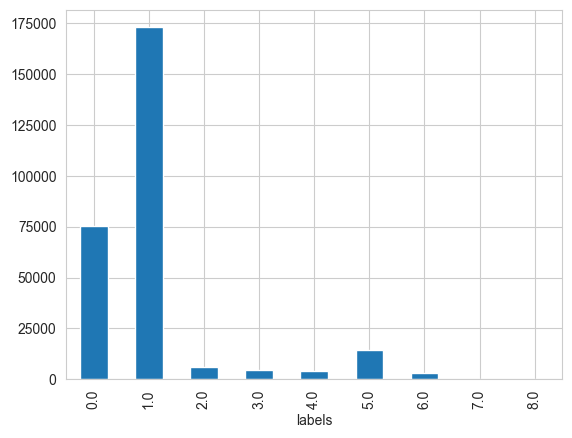

In [383]:
#quantidade de clientes em cada grupo grafico de barras ordenado por label
ds_historico_final['labels'].value_counts().sort_index().plot(kind='bar')

In [384]:
ds_historico_final.groupby(['foto_mes', 'labels']).mean().unstack()

active_quarter                                                    \
labels              0.0       1.0       2.0       3.0       4.0       5.0   
foto_mes                                                                    
201901         0.954783  0.927545  0.992470  0.990000  0.990566  0.993307   
201902         0.948435  0.925696  0.983871  0.982759  0.988426  0.992188   
201903         0.946554  0.926020  0.979430  0.979328  0.989637  0.997257   
201904         0.941693  0.923144  0.982456  0.985915  0.986072  0.987179   
201905         0.941447  0.920056  0.984436  0.987616  0.990506  0.995562   
201906         0.934742  0.917217  0.975359  0.987013  0.982935  0.995562   
201907         0.934525  0.917255  0.980477  0.992908  0.985240  0.993865   
201908         0.927841  0.917903  0.976359  0.996226  0.991870  0.993740   
201909         0.920851  0.917314  0.980926  0.987705  0.986111  0.991803   
201910         0.924012  0.916879  0.975758  0.990826  0.989362  0.981575   
201911         0.914519  0.912148  0.968966  0.979381  0.982456  0.982456   
201912         0.913662  0.907462  0.983051  0.994286  0.977612  0.986940   
202001         0.902295  0.903432  0.928177  0.992754  0.965517  0.988395   
202002         0.895501  0.901632  0.910000  1.000000  0.958763  0.982422   
202003         0.884468  0.891061  0.881356  1.000000  0.969697  0.985944   
202004         0.851304  0.884150  1.000000  0.987013  0.948276  0.983773   
202005         0.834086  0.873823  1.000000  1.000000  0.960784  0.985537   
202006         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
202007         0.810970  0.872518  0.722222  0.984127  0.925926  0.982942   
202008         0.816393  0.867132  1.000000  0.983607  0.941176  0.973333   
202009         0.798595  0.866084  1.000000  0.982456  0.893617  0.981265   
202010         0.777915  0.857760  1.000000  0.981132  0.883721  0.977941   
202011         0.752462  0.854979  1.000000  0.981481  0.860465  0.975871   
202012         0.723120  0.864045  1.000000  0.959184  0.906977  0.985673   
202101         0.706019  0.867137  1.000000  0.954545  0.825000  0.984615   
202102         0.708512  0.871411  1.000000  0.976190  0.769231  0.989583   
202103         0.725673  0.878511  1.000000  0.911765  0.794118  0.996063   
202104         0.721774  0.875934  1.000000  0.827586  0.785714  0.994924   
202105         0.701550  0.880205  1.000000  0.863636  0.888889  1.000000   
202106         0.745455  0.904401       NaN  0.875000  0.666667  1.000000   

                                       cliente_vip  ... Visa_mpagominimo  \
labels         6.0       7.0       8.0         0.0  ...              8.0   
foto_mes                                            ...                    
201901    0.653061  0.500000       NaN    0.002954  ...              NaN   
201902    0.650000  0.625000       NaN    0.002927  ...              NaN   
201903    0.659686  0.400000       NaN    0.002579  ...              NaN   
201904    0.657895  0.416667       NaN    0.002684  ...              NaN   
201905    0.655556  0.600000       NaN    0.002557  ...              NaN   
201906    0.624277  0.727273       NaN    0.002642  ...              NaN   
201907    0.620482  0.666667       NaN    0.002751  ...              NaN   
201908    0.621951  0.461538       NaN    0.002557  ...              NaN   
201909    0.643312  0.615385       NaN    0.002363  ...              NaN   
201910    0.660000  0.571429       NaN    0.002736  ...              NaN   
201911    0.619048  0.562500       NaN    0.002828  ...              NaN   
201912    0.594406  0.500000       NaN    0.002646  ...              NaN   
202001    0.568182  0.571429  1.000000    0.000348  ...      3671.490000   
202002    0.554622  0.500000  1.000000    0.000363  ...      3624.570000   
202003    0.547170  0.500000  1.000000    0.000000  ...      3495.540000   
202004    0.509804  0.500000  1.000000    0.000000  ...         0.000000   
202005    0.536842  0.4

In [385]:
ds_historico_final.groupby(['foto_mes', 'labels'])['mcomisiones'].mean().unstack()

labels,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
foto_mes,,,,,,,,,
201901,1022.029914,885.772604,1173.575075,1393.119900,1315.276722,581.216506,859.918316,217.218333,NaN
201902,693.363004,627.829682,980.195587,1128.565961,911.118819,445.628372,546.310750,53.668750,NaN
201903,752.406348,692.057286,933.070427,1096.786899,1160.987254,439.585213,438.625969,160.160000,NaN
201904,820.582952,733.108835,1028.251719,1282.484563,1504.688663,577.838348,547.770105,161.039167,NaN
201905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
201906,683.443334,669.026570,1080.354168,1176.036201,912.540307,495.605754,481.047341,93.822727,NaN
201907,832.793144,736.795083,1141.107440,1171.168901,1071.606273,606.785123,490.073795,8.981111,NaN
201908,825.689611,775.766546,1085.597754,1360.661925,1259.960935,744.070031,590.822378,172.795385,NaN
201909,831.367637,811.154642,1279.566376,1041.913525,1765.946389,838.365902,1337.889873,61.210769,NaN


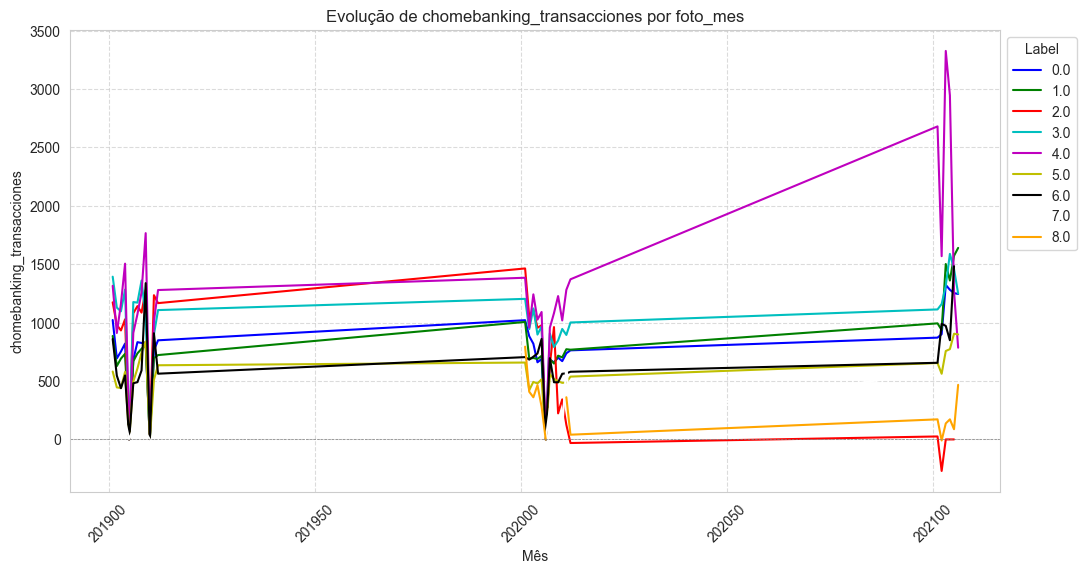

In [386]:
import matplotlib.pyplot as plt
import seaborn as sns  # Para melhorar a estética

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Define o estilo do gráfico

grouped = ds_historico_final.groupby(['foto_mes', 'labels'])['mcomisiones'].mean().unstack()

# Cores para as linhas
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange']

# Plote as linhas para cada rótulo com cores diferentes
for i, (label, data) in enumerate(grouped.items()):
    plt.plot(data.index, data, label=label, color=colors[i])

# Configurações de legenda e rótulos de eixo
plt.legend(title='Label', loc='best')
plt.xlabel('Mês')
plt.ylabel('chomebanking_transacciones')
plt.title('Evolução de chomebanking_transacciones por foto_mes')

# Adicione grade no fundo
plt.grid(True, linestyle='--', alpha=0.7)

# Melhore as informações sobre os meses no eixo x
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade

# Adicione uma linha de referência horizontal
plt.axhline(y=0, color='gray', linestyle='--', lw=0.5)

# Adicione uma legenda fora do gráfico
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))

# Ajuste os limites do eixo y, se necessário
# plt.ylim(0, 100)  # Substitua pelos limites desejados

# Aumente a qualidade da imagem de saída (dpi)
plt.savefig('grafico.png', dpi=300, bbox_inches='tight')

# Mostrar o gráfico
plt.show()


In [387]:
shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)

chomebanking_transacciones            0.022004
ctarjeta_visa_debitos_automaticos     0.016578
mtransferencias_emitidas              0.013244
mttarjeta_visa_debitos_automaticos    0.008407
thomebanking                          0.008173
                                        ...   
foto_mes                             -0.290685
cpayroll_trx                         -0.325235
ctarjeta_visa                        -0.364034
mcaja_ahorro                         -0.443888
ctrx_quarter                         -0.570689
Length: 153, dtype: float64

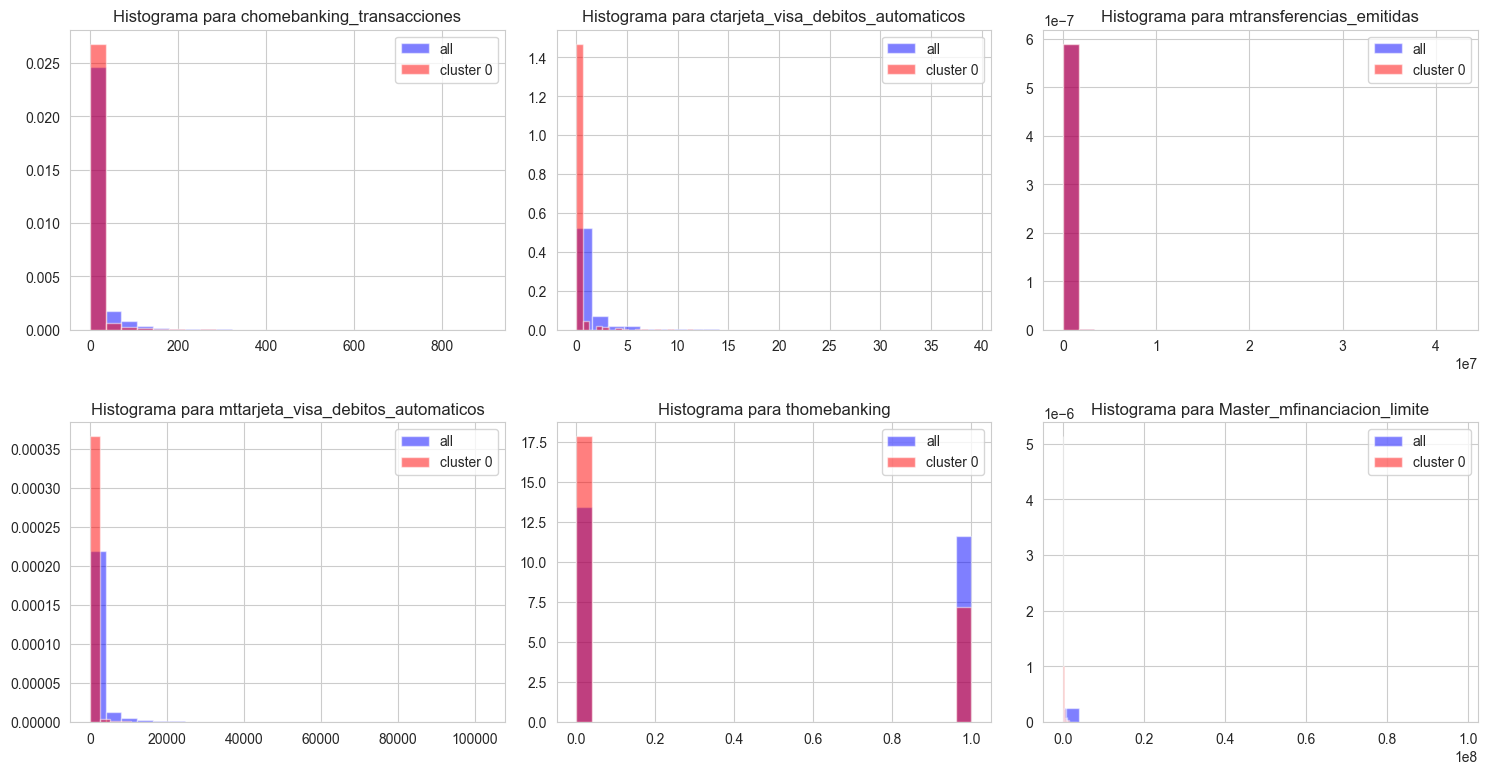

In [388]:
values_to_plot = shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 0][feature_names[i]], label='cluster 0', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [389]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)


chomebanking_transacciones    0.012043
Visa_status                   0.011846
mtransferencias_emitidas      0.011104
cdescubierto_preacordado      0.010794
ctarjeta_visa                 0.010609
                                ...   
mcaja_ahorro                 -0.260130
foto_mes                     -0.274485
cpayroll_trx                 -0.336288
mpayroll                     -0.393467
ctrx_quarter                 -0.473124
Length: 153, dtype: float64

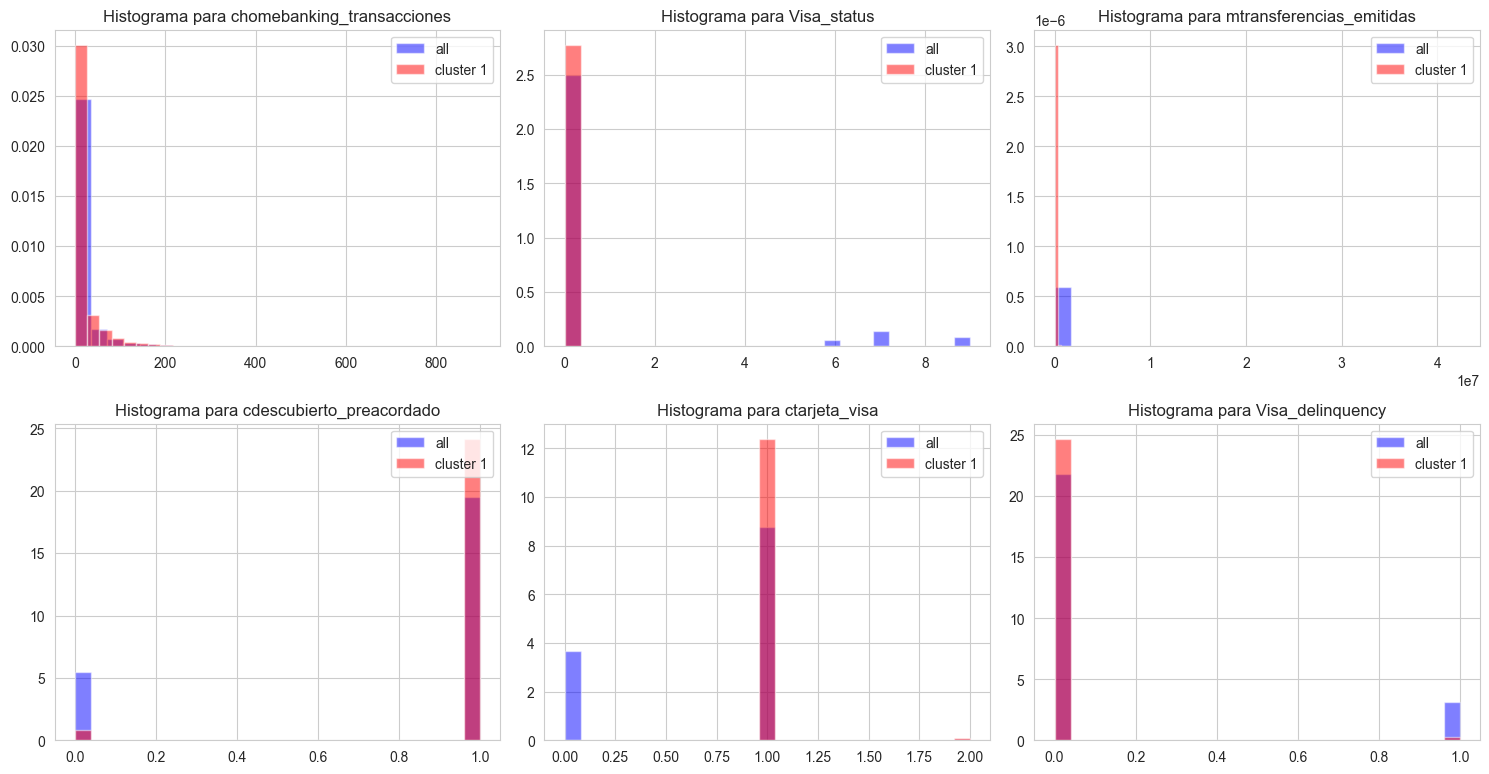

In [390]:
values_to_plot = shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 1][feature_names[i]], label='cluster 1', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [391]:
shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False)

mprestamos_personales         0.056193
mtransferencias_emitidas      0.012377
chomebanking_transacciones    0.009752
thomebanking                  0.003837
ccallcenter_transacciones     0.001777
                                ...   
mcuentas_saldo               -0.313185
Visa_delinquency             -0.342013
foto_mes                     -0.546998
mcaja_ahorro                 -0.787783
Visa_Finiciomora             -1.919429
Length: 153, dtype: float64

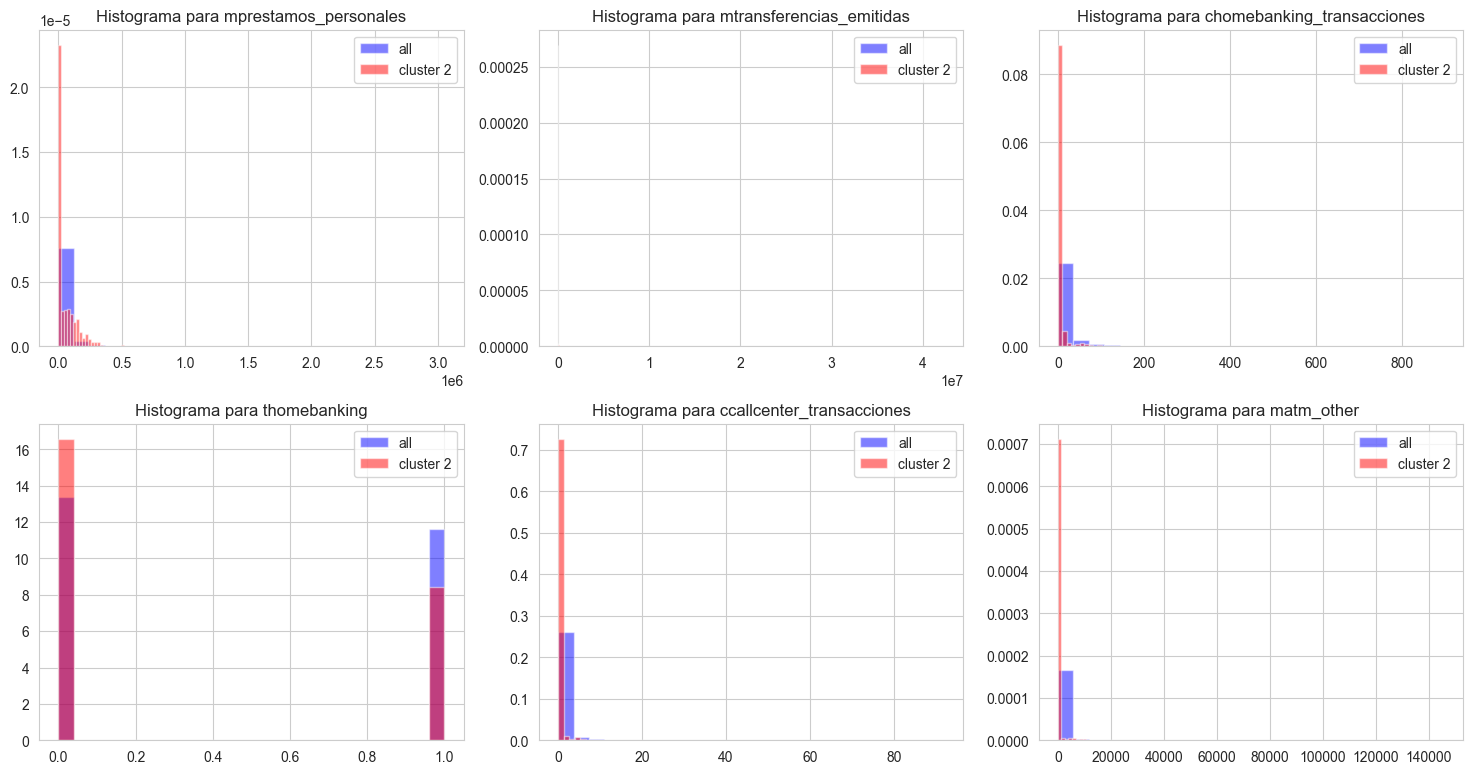

In [392]:
values_to_plot = shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 2][feature_names[i]], label='cluster 2', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [393]:
shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False)

mprestamos_personales         0.048835
internet                      0.018781
mtransferencias_emitidas      0.012475
chomebanking_transacciones    0.010856
ctarjeta_visa                 0.006604
                                ...   
mcuentas_saldo               -0.276646
Visa_delinquency             -0.333617
foto_mes                     -0.424370
mcaja_ahorro                 -0.617916
Visa_Finiciomora             -0.672087
Length: 153, dtype: float64

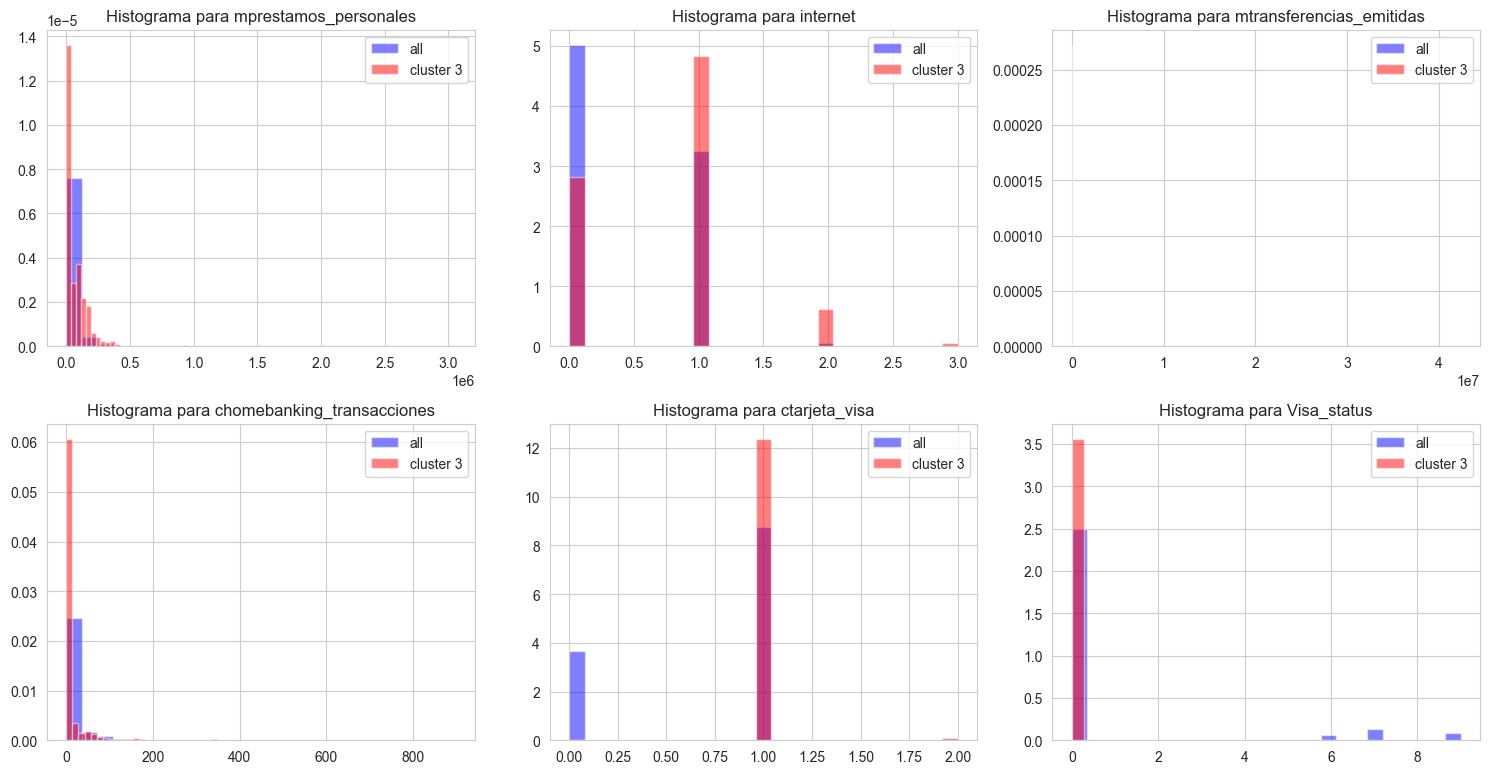

In [394]:
values_to_plot = shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 3][feature_names[i]], label='cluster 3', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [395]:
shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)

mprestamos_personales          0.090243
mtransferencias_emitidas       0.012480
Master_mfinanciacion_limite    0.010963
cprestamos_personales          0.006576
chomebanking_transacciones     0.005725
                                 ...   
ctarjeta_visa                 -0.354422
Visa_status                   -0.359010
foto_mes                      -0.571683
mcaja_ahorro                  -0.609555
Visa_Finiciomora              -1.188105
Length: 153, dtype: float64

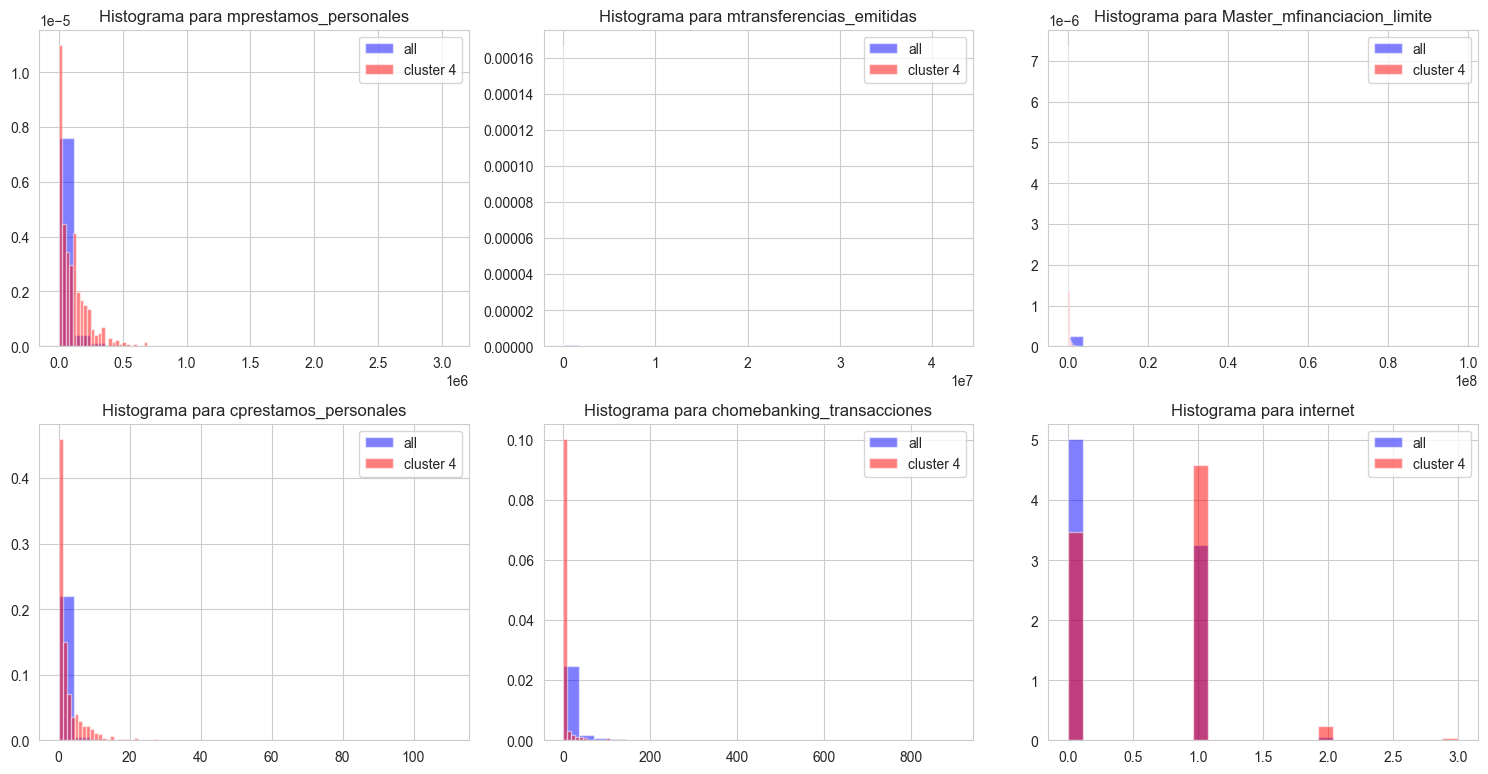

In [396]:
values_to_plot = shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 4][feature_names[i]], label='cluster 4', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [397]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)

cpayroll_trx                         0.335068
mpayroll                             0.258677
cextraccion_autoservicio             0.006483
mextraccion_autoservicio             0.003649
ctarjeta_visa_debitos_automaticos    0.002858
                                       ...   
mtarjeta_visa_consumo               -0.073264
ctarjeta_visa                       -0.089445
ccaja_ahorro                        -0.100035
Visa_mpagominimo                    -0.105734
foto_mes                            -0.231584
Length: 153, dtype: float64

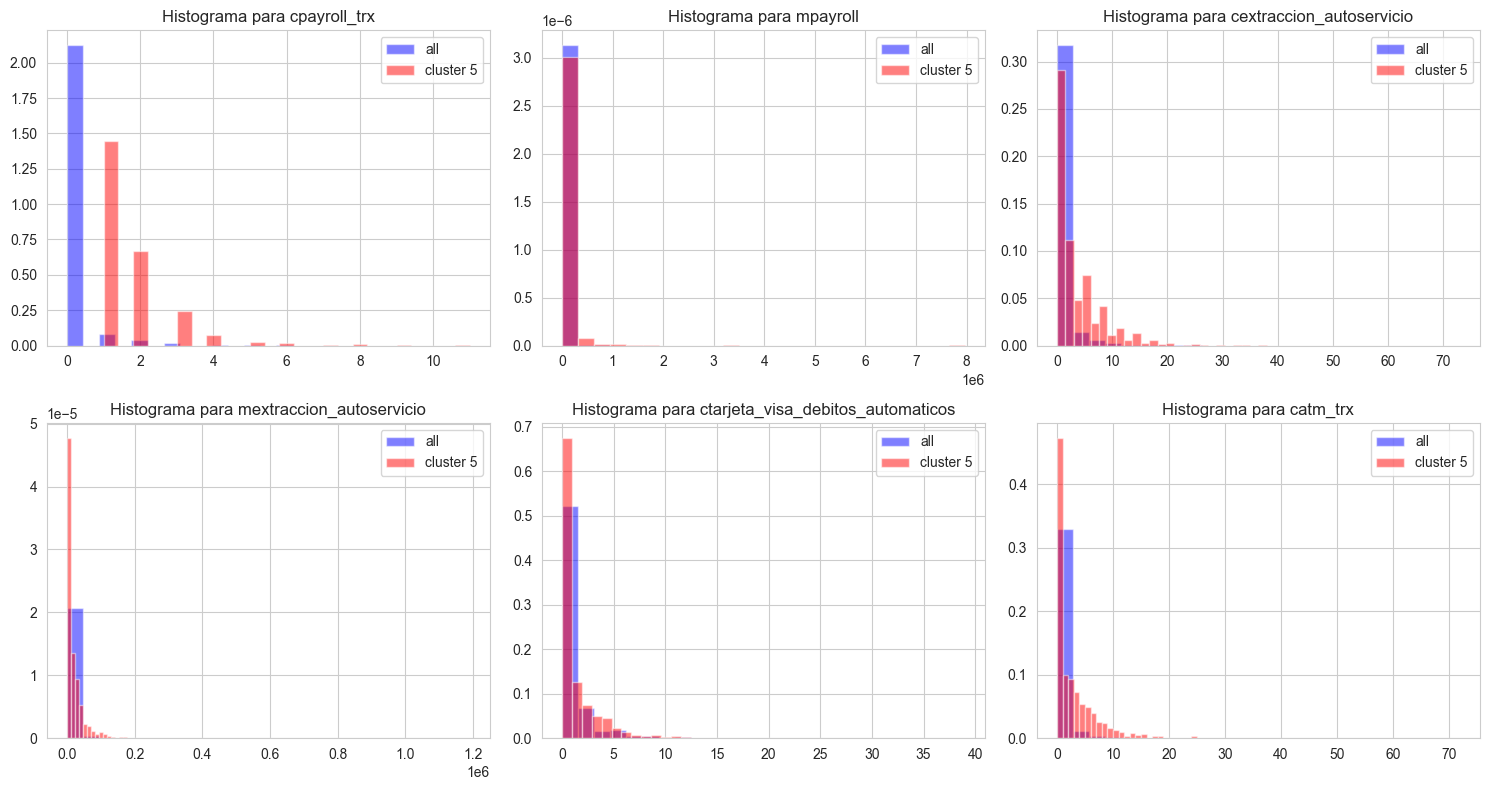

In [398]:
values_to_plot = shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 5][feature_names[i]], label='cluster 5', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [399]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False)

chomebanking_transacciones    0.031791
mtransferencias_emitidas      0.019717
ctarjeta_visa                 0.014517
Visa_status                   0.013653
thomebanking                  0.013123
                                ...   
mcuentas_saldo               -0.343936
mpayroll                     -0.356010
cdescubierto_preacordado     -0.433157
mcaja_ahorro                 -0.621951
ctrx_quarter                 -0.988345
Length: 153, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

In [420]:
#juntar os grupos 0 e 6, 1 e 4, 2 e 3, 5 e lancar em um novo dataframe, armazenar todos os dados de ds_historico_final no novo dataset
ds_labels_agrupados = ds_historico_final.copy()
ds_labels_agrupados['labels'] = ds_labels_agrupados['labels'].replace({6: 0, 4: 1, 3: 2, 5: 3})

In [422]:
ds_labels_agrupados['labels'].value_counts()
#remover registros com labels 7 e 8
ds_labels_importantes = ds_labels_agrupados[ds_labels_agrupados['labels'] < 4]


,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,...,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,labels,numero_de_cliente
11,201904,1,0,1,28,47,292.56,22108.38,1453.89,-9097.14,...,0.0,-26979.00,0.0,826.0,73421.45,17.0,0.0,18662.43,1.0,122037703
17,201904,1,0,1,49,55,2004.01,21158.29,1935.26,-708.24,...,0.0,0.00,0.0,1667.0,3881.45,3.0,0.0,34146.03,2.0,122077532
18,201904,1,0,1,49,64,2228.11,25682.97,1172.83,728.15,...,0.0,NaN,NaN,891.0,NaN,NaN,NaN,0.00,1.0,122081622
27,201904,1,0,1,59,57,3422.93,22285.73,1464.97,830.62,...,0.0,0.00,0.0,1724.0,9794.37,4.0,0.0,381400.95,1.0,122112417
40,201904,1,0,1,32,67,550.53,4502.17,312.73,64.27,...,0.0,NaN,NaN,1679.0,NaN,NaN,NaN,0.00,1.0,122132477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4562032,202105,0,0,0,38,68,3026.25,17089.26,2249.08,662.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,75059555
4562080,202105,1,0,0,67,189,1234.81,7190.50,78.53,44.46,...,6060.3,-15477.33,0.0,2814.0,0.00,0.0,0.0,598.23,1.0,75203125
4562386,202105,1,0,0,38,175,1148.67,19419.13,525.29,497.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,64446877
4562411,202105,1,0,0,76,216,655.74,15789.61,15.37,544.50,...,0.0,0.00,0.0,6243.0,0.00,0.0,0.0,4363.56,0.0,64974163


In [437]:
ds_labels_importantes['labels'].value_counts()
#montar um grafico de barras

labels
1.0    177253
0.0     78597
3.0     14626
2.0     10721
Name: count, dtype: int64

In [434]:
ds_labels_importantes.groupby('labels')['mcomisiones'].mean().sort_values(ascending=False)

labels
2.0    963.620011
0.0    706.848563
1.0    695.628612
3.0    499.817665
Name: mcomisiones, dtype: float64

In [435]:
ds_labels_importantes.groupby('labels')['mrentabilidad'].mean().sort_values(ascending=False)

labels
2.0    2387.051019
0.0    1777.857925
3.0    1722.162740
1.0    1332.978898
Name: mrentabilidad, dtype: float64

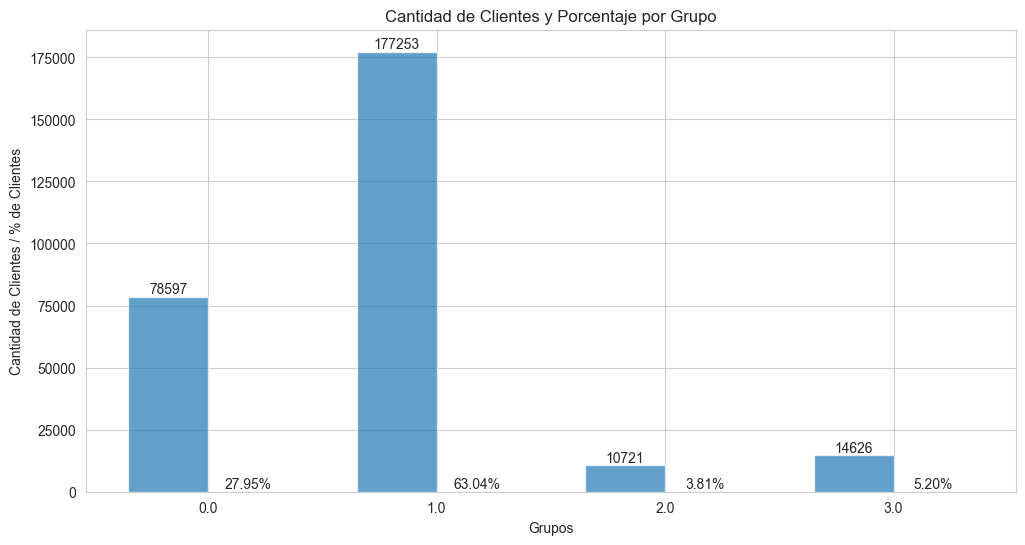

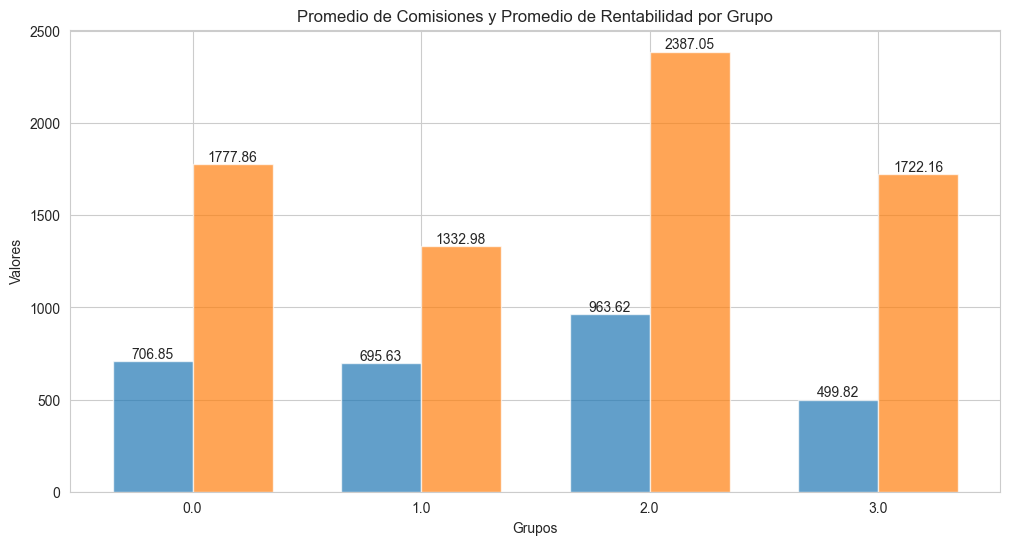

In [453]:
import matplotlib.pyplot as plt

# Datos
group_counts = ds_labels_importantes['labels'].value_counts()
mean_comisiones = ds_labels_importantes.groupby('labels')['mcomisiones'].mean()
mean_rentabilidad = ds_labels_importantes.groupby('labels')['mrentabilidad'].mean()

# Ordenar los grupos por etiqueta
group_labels = sorted(group_counts.index)

# Ancho de las barras
bar_width = 0.35

# Posiciones de las barras
bar_positions = range(len(group_labels))

# Calculando el porcentaje de clientes en cada grupo
total_clients = len(ds_labels_importantes)
percentage_clients = [count / total_clients * 100 for count in group_counts[group_labels]]

# Configuración del primer gráfico (Cantidad de Clientes con Porcentaje)
plt.figure(figsize=(12, 6))
plt.bar(bar_positions, group_counts[group_labels], width=bar_width, alpha=0.7)
plt.bar([pos + bar_width for pos in bar_positions], percentage_clients, width=bar_width, alpha=0.7, color='orange')

# Agregar los valores en las barras del primer gráfico
for pos, count, percentage in zip(bar_positions, group_counts[group_labels], percentage_clients):
    plt.text(pos, count, str(count), ha='center', va='bottom')
    plt.text(pos + bar_width, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Grupos')
plt.ylabel('Cantidad de Clientes / % de Clientes')
plt.title('Cantidad de Clientes y Porcentaje por Grupo')
plt.xticks([pos + bar_width / 2 for pos in bar_positions], group_labels)

# Configuración del segundo gráfico (Promedio de Comisiones y Rentabilidades)
plt.figure(figsize=(12, 6))
plt.bar(bar_positions, mean_comisiones[group_labels], width=bar_width, label='Promedio de Comisiones', alpha=0.7)
plt.bar([pos + bar_width for pos in bar_positions], mean_rentabilidad[group_labels], width=bar_width, label='Promedio de Rentabilidad', alpha=0.7)

# Agregar los valores en las barras del segundo gráfico
for pos, comisiones, rentabilidad in zip(bar_positions, mean_comisiones[group_labels], mean_rentabilidad[group_labels]):
    plt.text(pos, comisiones, f'{comisiones:.2f}', ha='center', va='bottom')
    plt.text(pos + bar_width, rentabilidad, f'{rentabilidad:.2f}', ha='center', va='bottom')

plt.xlabel('Grupos')
plt.ylabel('Valores')
plt.title('Promedio de Comisiones y Promedio de Rentabilidad por Grupo')
plt.xticks([pos + bar_width / 2 for pos in bar_positions], group_labels)

# Mostrar los gráficos
plt.show()

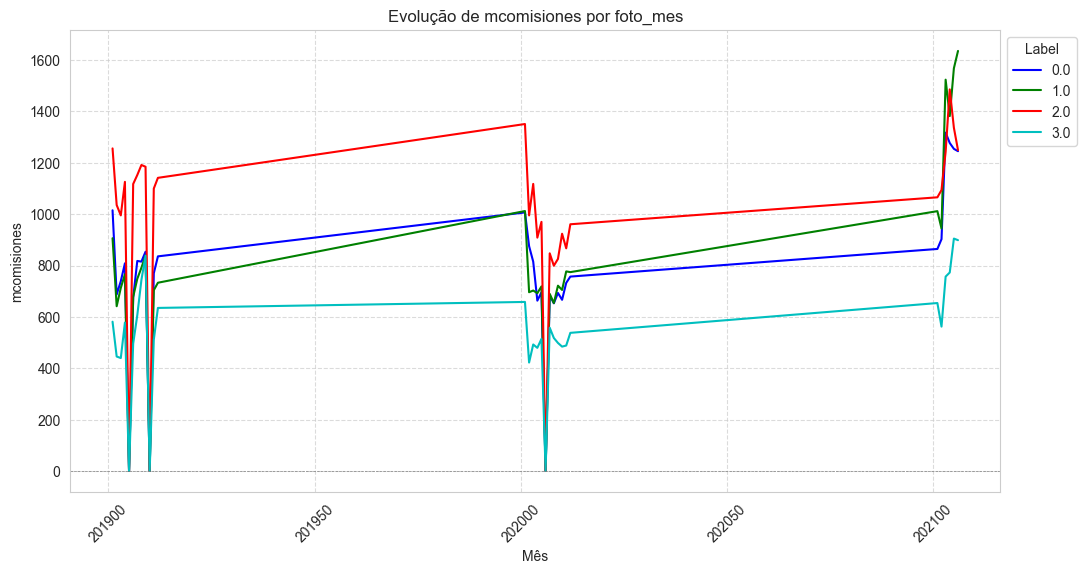

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns  # Para melhorar a estética

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Define o estilo do gráfico

grouped = ds_labels_importantes.groupby(['foto_mes', 'labels'])['mcomisiones'].mean().unstack()
colors = ['b', 'g', 'r', 'c']

for i, (label, data) in enumerate(grouped.items()):
    plt.plot(data.index, data, label=label, color=colors[i])

plt.legend(title='Label', loc='best')
plt.xlabel('Mês')
plt.ylabel('mcomisiones')
plt.title('Evolução de mcomisiones por foto_mes')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.axhline(y=0, color='gray', linestyle='--', lw=0.5)
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('grafico.png', dpi=300, bbox_inches='tight')
plt.show()


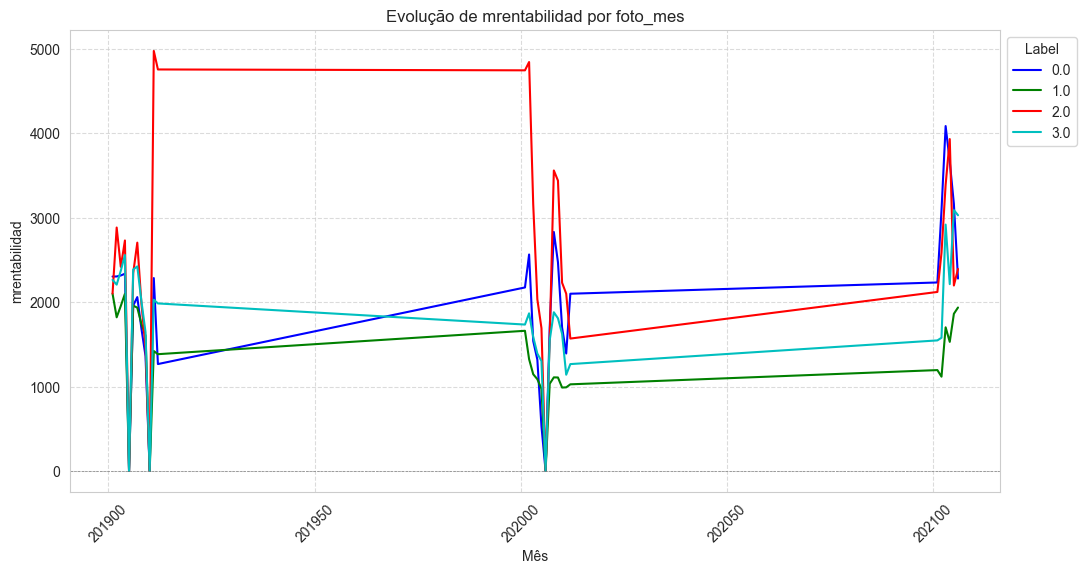

In [426]:
import matplotlib.pyplot as plt
import seaborn as sns  # Para melhorar a estética

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Define o estilo do gráfico

grouped = ds_labels_importantes.groupby(['foto_mes', 'labels'])['mrentabilidad'].mean().unstack()
colors = ['b', 'g', 'r', 'c']

for i, (label, data) in enumerate(grouped.items()):
    plt.plot(data.index, data, label=label, color=colors[i])

plt.legend(title='Label', loc='best')
plt.xlabel('Mês')
plt.ylabel('mrentabilidad')
plt.title('Evolução de mrentabilidad por foto_mes')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.axhline(y=0, color='gray', linestyle='--', lw=0.5)
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('grafico.png', dpi=300, bbox_inches='tight')
plt.show()


## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [400]:
np.random.seed(42)
continua_sample = clase_train[clase_train == 0].sample(1000).index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [401]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [402]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=42)
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

using precomputed metric; inverse_transform will be unavailable
n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


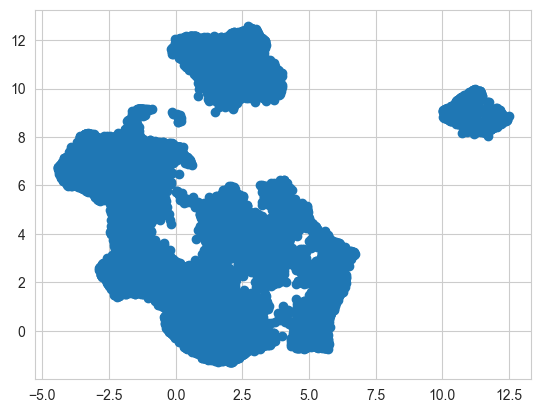

In [403]:
embedding_rf = UMAP.UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=40, random_state=42,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

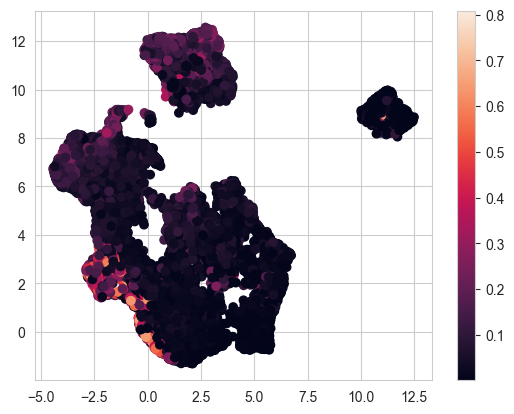

In [404]:
sc = plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=p_bajas)
plt.colorbar(sc)
plt.show()

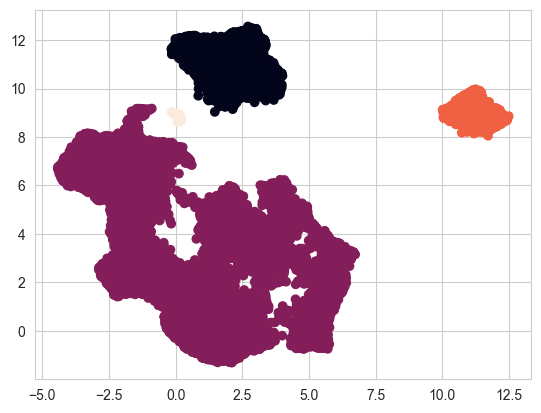

In [405]:
hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y_rf = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y_rf.labels_)
plt.show()

In [406]:
#listar os labels unicos
np.unique(y_rf.labels_).tolist()

[0, 1, 2, 3]

In [407]:
shap_bajas[y_rf.labels_ == 0].mean().sort_values(ascending=False)

chomebanking_transacciones            0.026705
ctarjeta_visa_debitos_automaticos     0.020658
mtransferencias_emitidas              0.014795
thomebanking                          0.011289
mttarjeta_visa_debitos_automaticos    0.010434
                                        ...   
foto_mes                             -0.300262
cpayroll_trx                         -0.310845
ctarjeta_visa                        -0.332874
mcaja_ahorro                         -0.534699
ctrx_quarter                         -0.656911
Length: 153, dtype: float64

In [409]:
shap_bajas[y_rf.labels_ == 1].mean().sort_values(ascending=False)

chomebanking_transacciones           0.012482
mtransferencias_emitidas             0.011284
ctarjeta_visa_debitos_automaticos    0.003608
thomebanking                         0.002406
matm_other                           0.001615
                                       ...   
foto_mes                            -0.298060
mcaja_ahorro                        -0.316516
cpayroll_trx                        -0.327261
mpayroll                            -0.369549
ctrx_quarter                        -0.448283
Length: 153, dtype: float64

In [410]:
shap_bajas[y_rf.labels_ == 2].mean().sort_values(ascending=False)

cpayroll_trx                         0.317932
mpayroll                             0.282562
cextraccion_autoservicio             0.008315
mextraccion_autoservicio             0.005460
ctarjeta_visa_debitos_automaticos    0.001745
                                       ...   
ctarjeta_visa                       -0.097171
ccaja_ahorro                        -0.100757
Visa_mpagominimo                    -0.155170
Visa_Finiciomora                    -0.172134
foto_mes                            -0.262913
Length: 153, dtype: float64

In [411]:
shap_bajas[y_rf.labels_ == 3].mean().sort_values(ascending=False)

mplazo_fijo_dolares           0.110809
cplazo_fijo                   0.100304
mpasivos_margen               0.074845
chomebanking_transacciones    0.021878
mtransferencias_emitidas      0.013384
                                ...   
foto_mes                     -0.255829
cpayroll_trx                 -0.283160
mpayroll                     -0.326517
mcaja_ahorro                 -0.441282
ctrx_quarter                 -0.682423
Length: 153, dtype: float64